In [1]:
import numpy as np
from common import *

import os, time
import tflearn
from io import StringIO
import copy
import pickle
from functools import partial
import cnn
import data_flow

from __future__ import division
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances

# Prepare word vectors

In [2]:
w2v_model = Word2Vec.load(join(DATA_FOLDER, 'vectors/w2v_model_300_w10'))

2017-09-08 19:14:42,298 [MainThread  ] [INFO ]  loading Word2Vec object from ../data/vectors/w2v_model_300_w10
2017-09-08 19:14:44,446 [MainThread  ] [INFO ]  loading wv recursively from ../data/vectors/w2v_model_300_w10.wv.* with mmap=None
2017-09-08 19:14:44,447 [MainThread  ] [INFO ]  loading syn0 from ../data/vectors/w2v_model_300_w10.wv.syn0.npy with mmap=None
2017-09-08 19:14:44,594 [MainThread  ] [INFO ]  setting ignored attribute syn0norm to None
2017-09-08 19:14:44,595 [MainThread  ] [INFO ]  loading syn1neg from ../data/vectors/w2v_model_300_w10.syn1neg.npy with mmap=None
2017-09-08 19:14:44,736 [MainThread  ] [INFO ]  setting ignored attribute cum_table to None
2017-09-08 19:14:44,737 [MainThread  ] [INFO ]  loaded ../data/vectors/w2v_model_300_w10


In [21]:
word_embeddings = w2v_model.wv.syn0.copy()
index2word = copy.deepcopy(w2v_model.wv.index2word)
del w2v_model

In [22]:
index2word.insert(0, 'PAD')
with open(join(DATA_FOLDER, "dictionary.pickle"), "wb") as output_file:
    pickle.dump(index2word, output_file)

In [17]:
stds = np.apply_along_axis(np.std, 1, word_embeddings)
pd.Series(stds).describe()

count    680760.000000
mean          0.193705
std           0.070574
min           0.000910
25%           0.137368
50%           0.178099
75%           0.244486
max           0.744395
dtype: float64

In [18]:
# 0.34 is chosen so the unknown vectors have (approximately) same variance as pre-trained ones
pad_vec = np.random.uniform(-0.34,0.34, word_embeddings.shape[1])
np.std(pad_vec)

0.20150940312078128

In [19]:
word_embeddings = np.insert(word_embeddings, 0, pad_vec, axis=0)

In [20]:
np.save(join(DATA_FOLDER, 'word_embeddings_%s.npy' % word_embeddings.shape[1]), word_embeddings)

# Load input data

In [2]:
word_embeddings = np.load(join(DATA_FOLDER, 'word_embeddings_300.npy'))
with open(join(DATA_FOLDER, "dictionary.pickle"), "rb") as input_file:
    index2word = pickle.load(input_file)

In [3]:
ids = glob('../data/corpus/**.txt')
with open(join(DATA_FOLDER, 'sims.json'), 'r') as f:
    sims = json.load(f)

In [4]:
triples_all = list(data_flow.random_triples(sims, ids, num_epochs=1, seed=1))
_triples, triples_test = train_test_split(triples_all, test_size=0.1, random_state=0)
triples_train, triples_val = train_test_split(_triples, test_size=0.1, random_state=0)

print(len(triples_train), len(triples_val), len(triples_test))

100%|██████████| 368458/368458 [00:07<00:00, 49032.49it/s]


(619669, 68853, 76503)


In [5]:
# triples_all = pd.read_csv(join(DATA_FOLDER, 'mpk_flow.csv.gz'), sep=' ', header=None)
# triples_all = triples_all[triples_all[2] != '59a969f1782b1b893a912539']

In [6]:
def add_fname(_id):
    return join(DATA_FOLDER, 'corpus', _id + '.txt')

In [7]:
# triples_train, triples_val, triples_test = [], [], []
# for epoch_data in np.array_split(triples_all, 3)[:1]:
#     _triples, _test = train_test_split(epoch_data, test_size=0.1, random_state=0, shuffle=False)
#     _train, _val = train_test_split(_triples, test_size=0.1, random_state=0, shuffle=False)

#     triples_train += [[add_fname(a), add_fname(b), add_fname(c)] for a,b,c in _train.values]
#     triples_val += [[add_fname(a), add_fname(b), add_fname(c)] for a,b,c in _val.values]
#     triples_test += [[add_fname(a), add_fname(b), add_fname(c)] for a,b,c in _test.values]
    
# logging.info('train %s val %s test %s' % (len(triples_train), len(triples_val), len(triples_test)))

In [8]:
vocab_size, embedding_size = word_embeddings.shape
n_sents, n_words = 123, 40
batch_size = 64
num_epochs = 1
learning_rate = 0.001

sent_filter_sizes = [1, 2, 3, 4, 5]
sent_nb_filter = 10
sent_embed_size = 128
sent_kmax = 4

doc_filter_sizes = [1, 2, 3, 4, 5]
doc_nb_filter = 10
doc_embed_size = 200
doc_kmax = 4

# Train

In [10]:
reload(cnn)

logging.info('start training ...')
start_time = time.time()

finished = False
try:
    tf.reset_default_graph()
    tf.set_random_seed(0)
    session_conf = tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        X, fnames_batch = data_flow.input_pipeline(
            triples_train[:batch_size*3], [n_sents, n_words], 
            batch_size=batch_size, num_epochs=num_epochs)

        model = cnn.TextCNN(
            n_sents,
            n_words,
            vocab_size,
            embedding_size,
            batch_size,
            sent_filter_sizes=sent_filter_sizes,
            sent_nb_filter=sent_nb_filter,
            sent_embed_size=sent_embed_size,
            doc_filter_sizes=doc_filter_sizes,
            doc_nb_filter=doc_nb_filter,
            doc_embed_size=doc_embed_size,
            sent_kmax=sent_kmax,
            doc_kmax=doc_kmax,
            learning_rate=learning_rate)
        train_op = model.optimize(X)

        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])

        model.init_summary()
        #!!!! index is shifted by 1
        model.init_lookup_table(word_embeddings)

#         pprint([n.name for n in tf.get_default_graph().as_graph_def().node])

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        try:
            while not coord.should_stop():
                _, step, loss, summary = sess.run([
                    train_op, model.global_step, model.loss_op,
                    model.merged_summary_op
                ], feed_dict = {model.phase: 1})
                model.add_summary(summary, step)
                logging.info('step %s, loss %s' % (step, loss))
        except tf.errors.OutOfRangeError:
            logging.info('Done training -- epoch limit reached')
        finally:
            # When done, ask the threads to stop.
            coord.request_stop()

        # Wait for threads to finish.
        coord.join(threads)
        model.save(step)
        finished = True

except Exception as e:
    logging.exception("train error")
    send_email('notebook_url', subject='train error', body=e)
finally:
    if finished:
#     send_email('notebook_url', subject='finished training')
        pass
        
logging.info("--- %s seconds ---" % (time.time() - start_time))

2017-09-14 17:04:31,165 [MainThread  ] [INFO ]  start training ...
2017-09-14 17:04:31,537 [MainThread  ] [INFO ]  sent_out_size 200, doc_out_size 200
2017-09-14 17:04:31,538 [MainThread  ] [INFO ]  sent_embed_size 128, doc_embed_size 200
2017-09-14 17:04:54,435 [MainThread  ] [INFO ]  step 1, loss 0.493278
2017-09-14 17:05:13,541 [MainThread  ] [INFO ]  step 2, loss 0.453561
2017-09-14 17:05:31,858 [MainThread  ] [INFO ]  step 3, loss 0.391074
2017-09-14 17:05:31,861 [MainThread  ] [INFO ]  Done training -- epoch limit reached
2017-09-14 17:05:34,042 [MainThread  ] [INFO ]  --- 62.8675031662 seconds ---


# Test

In [9]:
model_dir = join(DATA_FOLDER, 'models')
!ls {model_dir+'/*.meta'}

../data/models/2017-09-12 06:48:30.232017-3000.meta
../data/models/2017-09-13 03:45:02.521079-9682.meta
../data/models/2017-09-13 15:57:25.781316-3.meta
../data/models/2017-09-13 19:15:36.168251-3.meta
../data/models/2017-09-14 17:05:31.877463-3.meta
../data/models/2017-09-15 02:18:39.674838-9682.meta


In [10]:
def last_model(model_dir):
    fnames = glob(join(model_dir, '*.meta'))
    return max(fnames)

In [11]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

chunked = list(chunks(ids, 3))
print(chunked.pop())
logging.info('len(chunked) = %s' % len(chunked))

2017-09-15 14:27:53,023 [MainThread  ] [INFO ]  len(chunked) = 422394


['../data/corpus/5984b84fb6b1132eeb638535.txt']


https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/4_Utils/save_restore_model.py

In [12]:
doc_embeds, fnames = [], []

In [10]:
finished = False
try:
    tf.reset_default_graph()
    tf.set_random_seed(0)
    session_conf = tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)    
    with sess.as_default():
        X, fnames_batch = data_flow.input_pipeline(
            chunked[:batch_size*100], [n_sents, n_words], batch_size=batch_size, 
            num_epochs=1, shuffle=False)

        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])

        # do not restore before global initialization, otherwise all weights are set to default !!!
        saver = tf.train.import_meta_graph(last_model(model_dir), input_map={'X':X})
        saver.restore(sess, tf.train.latest_checkpoint(model_dir))
        graph = tf.get_default_graph()

        op_name = 'optimize/loss/doc_embed_normalized'
        doc_embed_normalized = graph.get_operation_by_name(op_name).outputs[0]

        anchor, positive, negative = tf.unstack(
            tf.reshape(doc_embed_normalized, [-1, 3, doc_kmax * doc_nb_filter * len(doc_filter_sizes)]),
            3, 1)
        _loss = cnn.triplet_loss(anchor, positive, negative)

#         pprint([n.name for n in tf.get_default_graph().as_graph_def().node])

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        step = 0
        try:
            while not coord.should_stop():
                [batch_embeds, loss, _names] = sess.run([doc_embed_normalized, 
                                                         _loss, fnames_batch])
                doc_embeds.append(batch_embeds)
                fnames += list(_names)
                logging.info('step %s, loss %s' % (step, loss))
                step+=1
        except tf.errors.OutOfRangeError:
            logging.info('Done testing -- epoch limit reached')
        finally:
            # When done, ask the threads to stop.
            coord.request_stop()

        # Wait for threads to finish.
        coord.join(threads)
        finished = True
        
except Exception as e:
    logging.exception("test error")
#     send_email('notebook_url', subject='test error', body=e)
finally:
    if finished:
#         send_email('notebook_url', subject='finished testing')
        pass

SyntaxError: invalid syntax (<ipython-input-10-3fb362e3db47>, line 3)

In [55]:
fnames = np.concatenate(fnames)
doc_embeds_reshaped = np.reshape(np.concatenate(doc_embeds), [-1, doc_embed_size])

In [28]:
margin = 0.5

In [14]:
# np.save('../data/doc_embeds_reshaped_1ep.npy', doc_embeds_reshaped)
# np.save('../data/fnames_1ep.npy', fnames)

In [29]:
doc_embeds_reshaped = np.load('../data/saved/doc_embeds_reshaped_1ep_%s.npy' % margin)
fnames = np.load('../data/saved/fnames_1ep_%s.npy' % margin)

In [30]:
len(fnames)

1267008

# Manualy evaluate

In [87]:
ix0 = 12
triples_test[ix0]
ix = list(fnames).index(triples_test[ix0][0])

In [40]:
ix = np.where(fnames == '../data/corpus/59a7bc58782b1b893a56a747.txt')[0][0]

In [41]:
test_fn = fnames[ix]
test_vec = doc_embeds_reshaped[ix]

In [42]:
test_fn

'../data/corpus/59a7bc58782b1b893a56a747.txt'

In [43]:
dists = np.sum(np.square(doc_embeds_reshaped - test_vec), 1)

In [44]:
ixs = dists.argsort()
fnames[ixs][:201]

array(['../data/corpus/59a7bc58782b1b893a56a747.txt',
       '../data/corpus/5984c8fab6b11375b563853b.txt',
       '../data/corpus/5984c00ab6b1130ebd638546.txt',
       '../data/corpus/5984caeeb6b1130a976384f3.txt',
       '../data/corpus/5984b99eb6b113414f63851c.txt',
       '../data/corpus/5984c8d8b6b11372df638533.txt',
       '../data/corpus/5984c8ebb6b11374c2638500.txt',
       '../data/corpus/5984cd13b6b1131edb638551.txt',
       '../data/corpus/5984c85db6b1136d83638518.txt',
       '../data/corpus/5984dc1fb6b11325ff63851b.txt',
       '../data/corpus/5984d238b6b1134e48638544.txt',
       '../data/corpus/5984c4ebb6b1134aa0638516.txt',
       '../data/corpus/5984c501b6b1134c7d638543.txt',
       '../data/corpus/5984cae7b6b1130967638549.txt',
       '../data/corpus/5984c88bb6b1136eef6384f7.txt',
       '../data/corpus/5984c64fb6b113584a638502.txt',
       '../data/corpus/5984d203b6b1134a9b6384f0.txt',
       '../data/corpus/5984dc43b6b113280f63853d.txt',
       '../data/corpus/5984b

In [93]:
dists[ixs]

array([ 0.        ,  0.02066471,  0.02163484, ...,  1.88739419,
        1.88992715,  1.90557218], dtype=float32)

In [94]:
[fn for fn in fnames if '5984c280b6b113301e638537' in fn]

['../data/corpus/5984c280b6b113301e638537.txt']

In [95]:
np.where(fnames[ixs] == '../data/corpus/5984bcbab6b11367d5638538.txt')

(array([364]),)

# Get statistics

In [31]:
with open(join(DATA_FOLDER, 'gold_mongo.json'), 'r') as f:
    gold = json.load(f)

In [32]:
names = pd.Series(range(len(fnames)), index = fnames)

In [33]:
test_vecs = []
for k in gold.keys():
    ix = names[add_fname(k)]
    tvec = doc_embeds_reshaped[ix]
    test_vecs.append(tvec)
    
dists = euclidean_distances(test_vecs, doc_embeds_reshaped)
sorted_ixs = np.argsort(dists, axis=1)
preds = {}
for k, _ixs in zip(gold.keys(), sorted_ixs):
    preds[k] = [basename(n).split('.')[0] for n in fnames[_ixs[1:201]]]

median
acc10     0.0
acc20     0.0
acc200    0.0
dtype: float64
mean
acc10     0.077899
acc20     0.125000
acc200    0.309511
dtype: float64


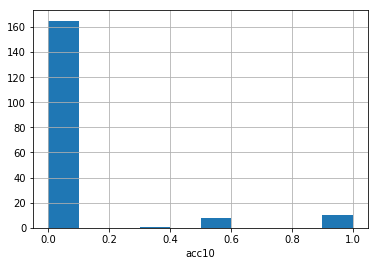

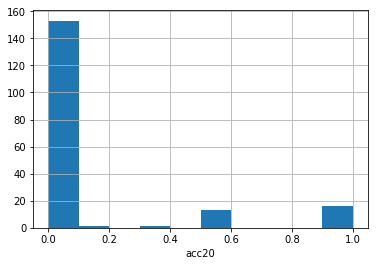

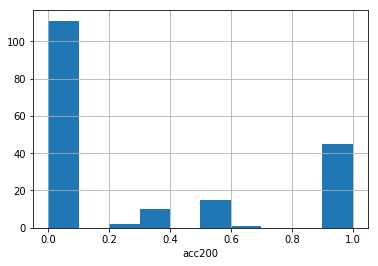

In [34]:
result = evaluate(preds, gold)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()

In [39]:
k = preds.keys()[0]
print(k)
preds[k]

59a7bc58782b1b893a56a747


['5984c8fab6b11375b563853b',
 '5984c00ab6b1130ebd638546',
 '5984caeeb6b1130a976384f3',
 '5984b99eb6b113414f63851c',
 '5984c8d8b6b11372df638533',
 '5984c8ebb6b11374c2638500',
 '5984cd13b6b1131edb638551',
 '5984c85db6b1136d83638518',
 '5984dc1fb6b11325ff63851b',
 '5984d238b6b1134e48638544',
 '5984c4ebb6b1134aa0638516',
 '5984c501b6b1134c7d638543',
 '5984cae7b6b1130967638549',
 '5984c88bb6b1136eef6384f7',
 '5984c64fb6b113584a638502',
 '5984d203b6b1134a9b6384f0',
 '5984dc43b6b113280f63853d',
 '5984bf1eb6b1130550638527',
 '5984b8c6b6b1133842638517',
 '5984c9f3b6b1130198638517',
 '5984be22b6b11377e6638550',
 '5984d4e3b6b113693e63850f',
 '5984c6d0b6b1135f5c6384f7',
 '5984bde1b6b113759763852b',
 '5984c6a5b6b1135b9d638511',
 '5984caedb6b1130a936384f6',
 '5984bc24b6b1135fda638541',
 '5984c17bb6b1132211638536',
 '5984b99cb6b113414b638512',
 '5984c876b6b1136d7f63852b',
 '5984b7d7b6b113295f638531',
 '5984c65bb6b1135856638546',
 '5984b7edb6b1132a75638522',
 '5984c85cb6b1136d83638513',
 '5984cd1eb6b1

# Develop

In [59]:
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(0)
    sess = tf.Session()
    with sess.as_default():
        
        r = list(range(100))
        ziped = zip(r[:-1], r[1:])
        t = tf.convert_to_tensor(ziped)
        
        def f(el):
            return el[0]
        
#         elems = np.array([1, 2, 3, 4, 5, 6])
#         squares = tf.map_fn(lambda x: x * x, elems)

        
        m = tf.map_fn(f, t)
            
        sess.run(tf.global_variables_initializer())
        
        [res] = sess.run([m])
        print(res)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98]
